In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np

# PyMC for Bayesian statistical modeling and probabilistic machine learning
import pymc as pm
# ArviZ for exploratory analysis of Bayesian models
import arviz as az

# Matplotlib and Seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read data into DataFrames
df4 = pd.read_csv('../Data/clean/Cohort4Clean.csv')
df5 = pd.read_csv('../Data/clean/Cohort5Clean.csv')
pics = pd.read_csv('../pics/pics.csv')

# Concatenate df4 and df5 to create a combined DataFrame
df = pd.concat([df4,df5])

# Drop duplicate rows based on the 'ID' column
df = df.drop_duplicates(subset=['ID'])

# Print the shape (number of rows and columns) of the combined and deduplicated DataFrame
print(df.shape)

(1370, 58)


In [3]:
df.head()

,Unnamed: 0,ID,A,Sex,People_226_h,People_128_h,Faces_147_v,Faces_011_h,People_210_h,Animals_142_h,...,EmotionalNumbing,Externalizing,AnxArousal,DysArousal,PCL,PTSD,MDD,PHQ,ASI,GAD
0,0,R_1eWeA2bpXfTVa7U,31.0,2.0,5.0,14.0,8.0,37.0,39.0,32.0,...,1.0,0.0,0.0,0.0,15.0,False,0,1.0,23.0,1.0
1,1,R_3hyYL426BBAz7LD,41.0,2.0,0.0,50.0,28.0,1.0,28.0,0.0,...,8.0,1.0,1.0,1.0,18.0,False,0,18.0,44.0,7.0
2,2,R_217dYHmIZxvv8iz,66.0,2.0,0.0,0.0,0.0,0.0,50.0,50.0,...,0.0,0.0,3.0,0.0,5.0,False,0,0.0,0.0,0.0
3,3,R_27xJwzHHs5sXCAQ,23.0,1.0,7.0,4.0,20.0,0.0,28.0,88.0,...,3.0,1.0,1.0,5.0,22.0,False,0,6.0,34.0,3.0
4,4,R_8uniYmVa8w3fzWN,42.0,1.0,3.0,27.0,19.0,25.0,26.0,36.0,...,7.0,1.0,0.0,7.0,29.0,False,1,18.0,47.0,6.0


In [4]:
df['AgeZ'] = (df['A'] - df['A'].mean()) / df['A'].std()
df['ENZ'] = (df['EmotionalNumbing'] - df['EmotionalNumbing'].mean()) / df['EmotionalNumbing'].std()

In [5]:
# Transform the DataFrame 'df' from wide to long format using 'melt'
# 'ID', 'PTSD', 'A', 'EmotionalNumbing', and 'PHQ' columns are kept as identifiers
# The values from columns 3 to 43 are reshaped into two columns: 'pic' (variable) and 'rating' (value)
df_long = pd.melt(df, id_vars=['ID','PTSD','AgeZ','ENZ','PHQ'], 
                  value_vars=list(df.columns[3:43]),
                  var_name='pic', 
                  value_name='rating')

# Merge 'df_long' with the 'pics' DataFrame on the 'pic' column
# This operation adds information from 'pics' to 'df_long' based on picture names
# The merged DataFrame is then sorted by 'PTSD' and 'ID'
df_long = df_long.merge(pics, left_on='pic', right_on='pic').sort_values(['PTSD','ID'])

# Scale the 'rating' column by dividing each value by 100
df_long['rating'] = df_long['rating']/100

# Create a new column 'scale_rating' by copying values from 'NAPSr' column
df_long['scale_rating'] = df_long['NAPSr']

# Filter the DataFrame to keep only rows where 'scale_rating' is less than 6
df_long = df_long[df_long['scale_rating']<6].reset_index(drop=True)

# Remove rows from 'df_long' where 'rating' has missing (NaN) values
# Store the resulting DataFrame in 'df_long_c'
df_long_c = df_long.dropna(subset='rating')

## Define models 

In [6]:
def pl5_hyper(df_all, idx, n_sub):
    

    with pm.Model() as five_PL:
        
        # hyper priors
        # Define hyperpriors for group-level parameters
        a1   = pm.TruncatedNormal('a1',   2, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',           10, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', 2, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', 2, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', 2, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', 4, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
                
        s = b[idx] 

        # Define prior for standard deviation of observations
        eps = pm.Gamma('eps', 1, 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**s)**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        # Sample from the posterior distribution
        trace = pm.sample()#tune = 3000, draws = 2000, target_accept = 0.99)

    return trace

In [7]:
def pl5_hyper_emotion(df_all, idx, n_sub):
    

    with pm.Model() as five_PL:
        
        # hyper priors
        # Define hyperpriors for group-level parameters
        a1   = pm.TruncatedNormal('a1',   2, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',           10, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', 2, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', 2, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', 2, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', 4, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
                
        EN_slope = pm.Normal('EN_slope', 0, 1)
        
        s = b[idx] + EN_slope * df_all['ENZ']

        # Define prior for standard deviation of observations
        eps = pm.Gamma('eps', 1, 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**s)**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        # Sample from the posterior distribution
        trace = pm.sample()#tune = 3000, draws = 2000, target_accept = 0.99)

    return trace

In [8]:
def pl5_hyper_age(df_all, idx, n_sub):
    

    with pm.Model() as five_PL:
        
        # hyper priors
        # Define hyperpriors for group-level parameters
        a1   = pm.TruncatedNormal('a1',   2, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',           10, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', 2, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', 2, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', 2, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', 4, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
             
        EN_slope = pm.HalfNormal('EN_slope', 1)
        Age_slope = pm.Normal('Age_slope', 0, 1)
        
        s = b[idx] + (EN_slope * df_all['ENZ'] +
                      Age_slope * df_all['AgeZ'])

        # Define prior for standard deviation of observations
        eps = pm.Exponential('eps', 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**s)**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        trace = pm.sample()#tune = 2000, draws = 2000, target_accept = 0.99)

    return trace

In [9]:
def pl5_hyper_inter(df_all, idx, n_sub):
    

    with pm.Model() as five_PL:
        
        # hyper priors
        # Define hyperpriors for group-level parameters
        a1   = pm.TruncatedNormal('a1',   2, 1, lower =  1) # Truncated Normal hyperprior for 'a1'
        a2   = pm.Normal('a2',           10, 1            ) # Normal hyperprior for 'a2'
        mu_b = pm.TruncatedNormal('mu_b', 2, 1, lower =  1) # Truncated Normal hyperprior for mean 'b'
        mu_c = pm.TruncatedNormal('mu_c', 2, 1, lower = .5) # Truncated Normal hyperprior for mean 'c'
        mu_d = pm.TruncatedNormal('mu_d', 2, 1, lower =  0) # Truncated Normal hyperprior for mean 'd'
        mu_g = pm.TruncatedNormal('mu_g', 4, 1, lower =  1) # Truncated Normal hyperprior for mean 'g'
        
        
        # Define priors for parameters of the 5PL regression
        a = pm.Beta('a',              a1, a2,                         shape = n_sub) # Beta distribution for lower asymptote
        b = pm.TruncatedNormal('b', mu_b,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for the slope
        c = pm.TruncatedNormal('c', mu_c,  1,  lower = .5, upper = 5, shape = n_sub) # Truncated Normal distribution for mid point
        d = pm.TruncatedNormal('d', mu_d,  1,  lower = .5,            shape = n_sub) # Truncated Normal distribution for upper asymptote
        g = pm.TruncatedNormal('g', mu_g,  1,  lower = .8,            shape = n_sub) # Truncated Normal distribution for asymmetry factor
             
        EN_slope = pm.HalfNormal('EN_slope', 1)
        Age_slope = pm.Normal('Age_slope', 0, 1)
        Inter_slope = pm.Normal('Inter_slope', 0, 1)
        
        s = b[idx] + (EN_slope * df_all['ENZ'] +
                      Age_slope * df_all['AgeZ'] +
                      Inter_slope * df_all['ENZ'] * df_all['AgeZ'])

        # Define prior for standard deviation of observations
        eps = pm.Exponential('eps', 1)

        # Define the 5PL regression model   
        y_hat = d[idx] + ((a[idx]-d[idx])/(1+(df_all['scale_rating'].values/c[idx])**s)**g[idx])

        # Define likelihood function using observed data
        rating = pm.Normal('rating',y_hat, eps, observed=df_all.rating)

        trace = pm.sample()#tune = 2000, draws = 2000, target_accept = 0.99)

    return trace

## Run models

In [10]:
# Assign a unique integer identifier to each unique ID in the dataset.
# The 'rank' method provides a ranking to each unique ID and 'dense' ensures there are no gaps between ranks.
# Subtracting 1 to make the ranking start from 0.
df_long_c['sub_id'] = df_long_c['ID'].rank(method='dense')-1

# Count the number of unique IDs (subjects)
n_subs = len(df_long_c['ID'].unique())

# Convert the 'sub_id' column to integer type as indices are typically integers.
idx = df_long_c['sub_id'].astype(int)

# Apply the 'pl5_hyper_emotion' Bayesian hierarchical model function to the entire dataset.
trace_en = pl5_hyper_emotion(df_long_c, idx, n_subs)

# Generate a summary of the 'slope' parameter from the posterior traces.
az.summary(trace_en, var_names=['EN_slope'], hdi_prob=.89)

/tmp/ipykernel_16802/3049113466.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long_c['sub_id'] = df_long_c['ID'].rank(method='dense')-1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, EN_slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2418 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
EN_slope,0.087,0.032,0.033,0.137,0.001,0.001,1959.0,2473.0,1.0


In [11]:
trace_age = pl5_hyper_age(df_long_c, idx, n_subs)
trace_inter = pl5_hyper_inter(df_long_c, idx, n_subs)
trace_Neutral = pl5_hyper_emotion(df_long_c, idx, n_subs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, EN_slope, Age_slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2501 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, EN_slope, Age_slope, Inter_slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2765 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a1, a2, mu_b, mu_c, mu_d, mu_g, a, b, c, d, g, EN_slope, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2434 seconds.


In [24]:
compare_dict_en = {'Neutral': trace_Neutral,
                   'Emotional numbing': trace_en,
                  }

comp_en = az.compare(compare_dict_en)
comp_en

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Emotional numbing,0,20206.787565,2458.091574,0.000000,1.0,200.772358,0.000000,True,log
Neutral,1,20204.976698,2458.846863,1.810867,0.0,200.766108,1.414329,True,log


In [13]:
compare_dict_en = {
                   'Emotional numbing': trace_en,
                   'Age': trace_age,
                   'Interaction': trace_inter
                  }

comp_en = az.compare(compare_dict_en)
comp_en

/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/nachshon/anaconda3/envs/en/lib/python3.9

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Emotional numbing,0,20206.787565,2458.091574,0.000000,1.000000e+00,200.772358,0.000000,True,log
Age,1,20205.551183,2458.368868,1.236382,2.498002e-15,200.814421,1.566618,True,log
Interaction,2,20204.009873,2460.333319,2.777693,0.000000e+00,200.821072,1.685721,True,log


In [17]:
b = az.summary(trace_en, var_names=['b'])['mean']
b = b.reset_index(drop=True)
slope = az.summary(trace_en, var_names=['EN_slope'])['mean'][0]
df['b'] = b
df['en'] = df['b']+slope*df.ENZ

hdp_l = az.summary(trace_en, hdi_prob=.89, var_names=['EN_slope'])['hdi_5.5%'][0]
hdp_h = az.summary(trace_en, hdi_prob=.89, var_names=['EN_slope'])['hdi_94.5%'][0]

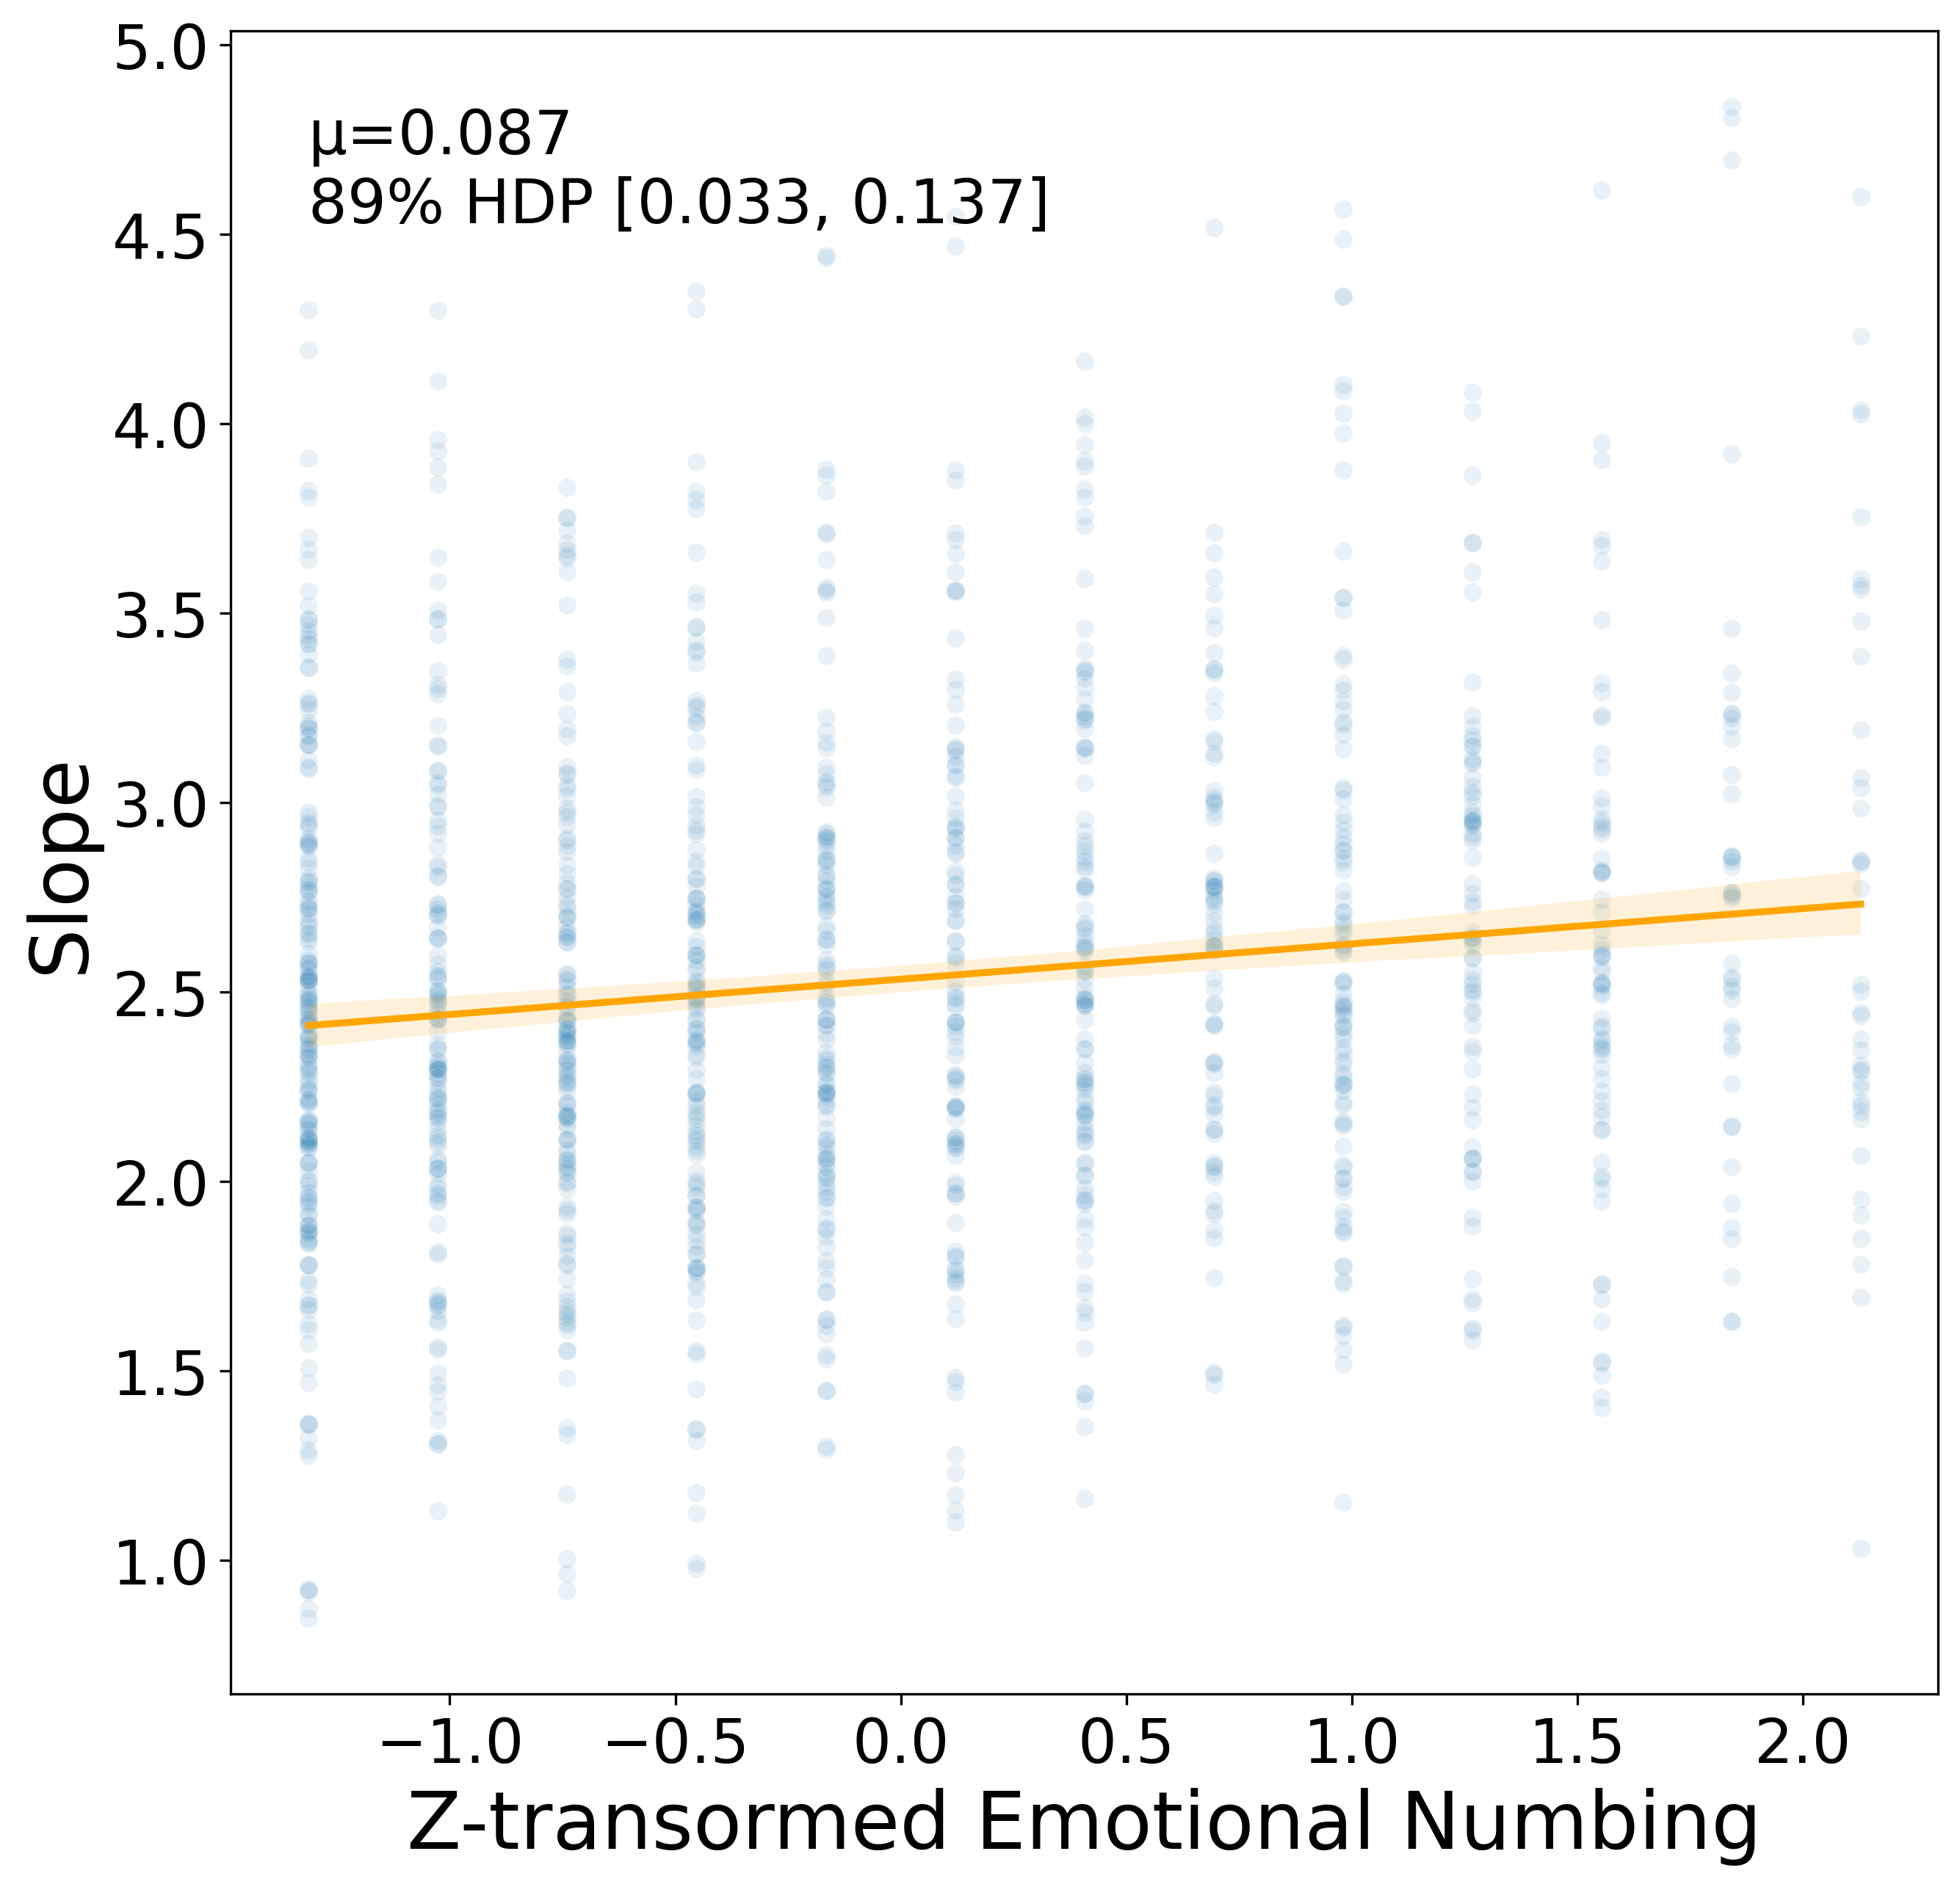

In [19]:
plt.figure(figsize=(10, 10), dpi=300)


sns.scatterplot(data=df, x='ENZ', y='en', alpha=0.1)
sns.regplot(data=df, x='ENZ', y='en', scatter=False, color='orange')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.xlabel('Z-transormed Emotional Numbing', fontsize=26)
plt.ylabel('Slope', fontsize=26)

# Add text at specified coordinates (x, y) with text size 20
text = f"μ={slope}\n89% HDP [{hdp_l}, {hdp_h}]"
plt.text(x=min(df['ENZ']), y=max(df['en']), s=text, fontsize=20, ha='left', va='top')

plt.show()